# 导入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline

In [8]:
path = 'C:/Users/hp/Desktop/data/'
train = pd.read_csv(path+'used_car_train_20200313.csv', sep=' ')
test = pd.read_csv(path+'used_car_testA_20200313.csv', sep=' ')

# 删除异常值

这段代码定义了一个名为 outliers_proc 的函数，用于清洗 pandas 数据框（DataFrame）中的异常值。它默认使用箱线图（Box Plot）的方法来识别并去除异常值，具体是通过计算四分位距（IQR）的倍数（默认为3倍）来确定异常值的范围。以下是该函数的详细解析：

**函数参数

·data: pandas 数据框（DataFrame），需要清洗的数据。

·col_name: 字符串，指定需要清洗的列名。

·scale: 数值，用于计算IQR的倍数，默认为3，表示IQR的3倍外视为异常值。

**函数内部实现

1、定义内部函数：box_plot_outliers，用于计算给定数据的异常值范围（即低于下界和高于上界的值），并返回这些值的布尔索引和具体的数值界限。

·使用data_ser.quantile(0.25)和data_ser.quantile(0.75)计算第一四分位数（Q1）和第三四分位数（Q3）。

·计算IQR（Q3 - Q1）。

·使用box_scale * IQR计算异常值的界限（即下界val_low和上界val_up）。

·返回低于下界和高于上界的布尔索引及具体界限值。

2、处理输入数据：复制原始数据以避免修改原始数据框。

3、识别并去除异常值：

·调用box_plot_outliers函数获取异常值的布尔索引和界限值。

·使用布尔索引从数据框中删除异常值。

·重置数据框的索引。

4、打印信息：

·打印被删除的异常值数量。

·打印清洗后数据框的行数。

·分别打印低于下界和高于上界的异常值的描述性统计信息。

5、可视化：

·使用seaborn的boxplot函数分别绘制原始数据和清洗后数据的箱线图，以便直观比较。

6、返回值：返回清洗后的数据框。

In [7]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

count: 963.000000 表示有963个数据点高于设定的上界。

mean: 846.836968 表示这些高于上界的数据点的平均值为846.84。

std: 1929.418081 表示这些数据的标准差很大，说明数据点之间的离散程度很高。

min: 376.000000 表示高于上界的数据点中的最小值是376。

25%, 50%, 75% 分别表示第一四分位数（400）、中位数（436）和第三四分位数（514），这些数据提供了数据分布的更多细节。

max: 19312.000000 表示高于上界的数据点中的最大值是19312，这是一个非常大的值，可能对整体数据的均值和标准差产生显著影响。

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


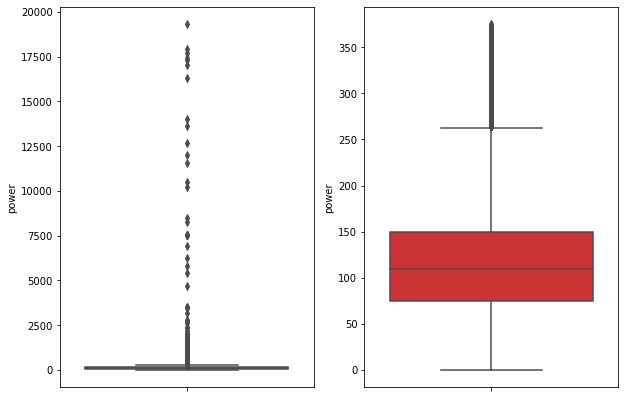

In [9]:
train = outliers_proc(train, 'power', scale=3)

# 特征构造

在您提供的代码中，您已经成功地将训练集和测试集合并为一个数据集 data，并添加了一个名为 train 的列来区分原始的训练集和测试集样本。接着，您计算了每辆汽车的使用时间 used_time，这是通过从注册日期 regDate 到创建日期 creatDate 的天数差来计算的。在处理日期时，您使用了 errors='coerce' 来避免格式错误导致的问题，这将无法转换为日期的条目转换为 NaT（Not a Time）。

关于 used_time 列中的空数据（即 NaN 值），您已经注意到有大约 15k 个样本的时间是有问题的。您正确地指出，删除这些缺失值可能会导致数据损失过多（占总样本量的 7.5%），这通常不是一个好的选择，特别是在使用能够处理缺失值的算法（如 XGBoost）时。

In [10]:
# 训练集和测试集放在一起，方便构造特征
train['train']=1
test['train']=0
data = pd.concat([train, test], ignore_index=True, sort=False)
# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 但是这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
data['used_time'].isnull().sum()

15072

In [11]:
# 从邮编中提取城市信息，因为是德国的数据，所以参考德国的邮编，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [12]:
# 计算每个品牌的销售统计量，并将其作为新的特征添加到整个数据集 data 中。
# 这里要以 train 的数据计算统计量
train_gb = train.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [13]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多，= =
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [14]:
# 利用好了，就可以删掉原始数据了
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [15]:
print(data.shape)
data.columns

(199037, 39)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [16]:
# 目前的数据其实已经可以给树模型使用了，所以我们导出一下
data.to_csv('data_for_tree.csv', index=0)

<AxesSubplot:ylabel='Frequency'>

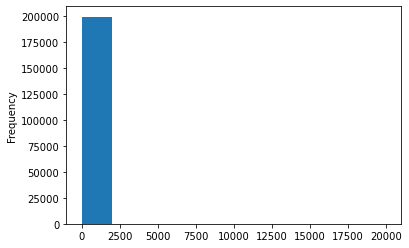

In [17]:
# 我们可以再构造一份特征给 LR NN 之类的模型用
# 之所以分开构造是因为，不同模型对数据集的要求不同
# 我们看下数据分布：
data['power'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

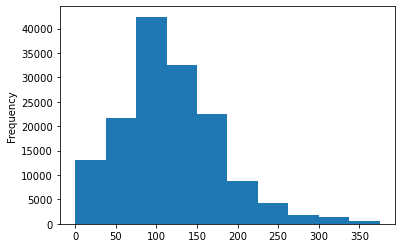

In [18]:
# 我们刚刚已经对 train 进行异常值处理了，但是现在还有这么奇怪的分布是因为 test 中的 power 异常值，
# 所以我们其实刚刚 train 中的 power 异常值不删为好，可以用长尾分布截断来代替
train['power'].plot.hist()

归一化是一种将数据的数值范围调整到特定区间（通常是0到1之间）的过程。这个过程通过重新缩放特征值来实现，使得所有特征值都落在相同的数值范围内。归一化对于许多基于距离的算法（如K-近邻算法、K-均值聚类）和需要计算权重的算法（如神经网络）特别重要，因为它可以帮助避免某些特征对结果产生过大的影响。

<AxesSubplot:ylabel='Frequency'>

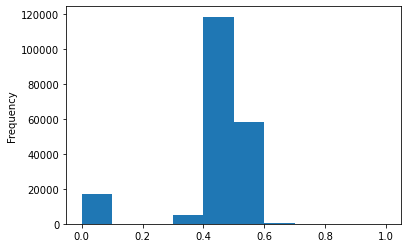

In [19]:
# 我们对其取 log，在做归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

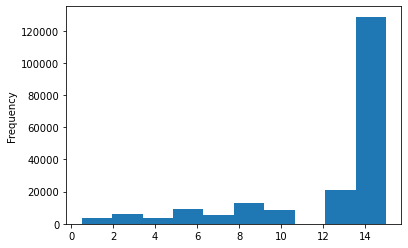

In [20]:
# km 的比较正常，应该是已经做过分桶了
data['kilometer'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

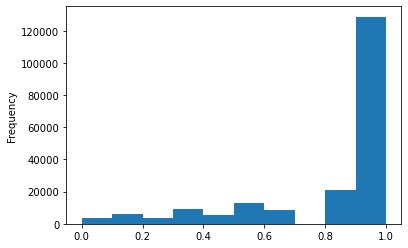

In [21]:
# 所以我们可以直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [22]:
# 除此之外 还有我们刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max   
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 这里不再一一举例分析了，直接做变换，
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

In [23]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [24]:
print(data.shape)
data.columns

(199037, 370)


Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

# 特征筛选

## 过滤式

在这段代码中，你正在使用Pandas库中的.corr()方法来计算数据集data中不同特征与价格（price）之间的Spearman等级相关系数。Spearman等级相关系数是衡量两个变量的依赖性的非参数指标，它不需要假设数据是线性关系或正态分布。这个方法尤其适用于衡量有序数据或等级数据之间的相关性。

下面是对你打印的每一行代码的解释：

print(data['power'].corr(data['price'], method='spearman'))
这行代码计算了车辆功率（power）与价格（price）之间的Spearman等级相关系数。这个系数将告诉你功率与价格之间是否存在单调关系（无论是增加还是减少）以及这种关系的强度。

print(data['kilometer'].corr(data['price'], method='spearman'))
这行代码计算了车辆行驶里程（kilometer）与价格（price）之间的Spearman等级相关系数。这个系数将揭示行驶里程与价格之间的单调关系，例如，通常预期行驶里程越高，价格越低（但这取决于具体的市场情况）。

print(data['brand_amount'].corr(data['price'], method='spearman'))
这行代码计算了品牌数量（brand_amount，这可能指的是某个品牌在市场上出售的车辆数量或其他类似的度量）与价格（price）之间的Spearman等级相关系数。这个系数可能反映了品牌市场覆盖度或知名度对价格的影响。

print(data['brand_price_average'].corr(data['price'], method='spearman'))
这行代码计算了品牌平均价格（brand_price_average）与单个车辆价格（price）之间的Spearman等级相关系数。这个系数可以帮助你理解品牌的平均价格是否与其个别车辆的价格有单调关系。

print(data['brand_price_max'].corr(data['price'], method='spearman'))
这行代码计算了品牌最高价格（brand_price_max）与单个车辆价格（price）之间的Spearman等级相关系数。这个系数揭示了品牌中最昂贵车型的价格与品牌下其他车型价格之间的单调关系。

print(data['brand_price_median'].corr(data['price'], method='spearman'))
这行代码计算了品牌价格中位数（brand_price_median）与单个车辆价格（price）之间的Spearman等级相关系数。这个系数可以帮助你了解品牌的价格分布中心与个别车辆价格之间的单调关系。

通过这些分析，你可以获得对车辆价格与不同特征之间关系的深入理解，这对于汽车市场的定价策略、消费者行为分析以及车辆评估等方面都非常有用。



In [25]:
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


在使用热图（Heatmap）展示数值特征之间的相关性时，主要是通过颜色的深浅来表示相关性的强度。通常，热图会使用一个颜色渐变来表示从负相关（一种颜色，如蓝色或绿色）到正相关（另一种颜色，如红色或黄色）的过渡，而颜色的深浅则反映了相关性的绝对值大小。

对于你给出的代码，这里是如何解读生成的热图的步骤：

1、颜色渐变：首先，你需要了解热图所使用的颜色渐变。默认情况下，seaborn（通常简称为sns）的热图可能会使用从蓝色（或绿色）到红色的渐变，其中蓝色（或绿色）代表负相关，红色代表正相关。但是，具体颜色可能因seaborn的版本或你的自定义设置而异。

2、颜色深浅：颜色的深浅表示了相关性的绝对值大小。颜色越深（无论是红色还是蓝色），表示两个特征之间的相关性越强；颜色越浅，表示相关性越弱。

3、对角线：热图的对角线（从左上角到右下角的线）上的元素是每个特征与其自身的相关性，理论上这些值都是1（完全正相关）。这些值在热图上通常会用不同的颜色或标记来区分，因为它们不代表特征之间的实际相关性。

4、解读特征之间的相关性：

·正相关：如果两个特征之间的颜色偏向红色，并且颜色较深，那么这表示这两个特征之间存在正相关关系。即，当一个特征的值增加时，另一个特征的值也倾向于增加。

·负相关：如果两个特征之间的颜色偏向蓝色（或绿色，取决于颜色方案），并且颜色较深，那么这表示这两个特征之间存在负相关关系。即，当一个特征的值增加时，另一个特征的值倾向于减少。

·无相关：如果两个特征之间的颜色接近热图的背景色（通常是白色或浅灰色），或者颜色非常浅，那么这表示这两个特征之间没有明显的相关性。

5、注意相关性系数的范围：在你的代码中，vmax=0.8 表示热图的颜色渐变将只反映相关性系数的绝对值在0到0.8之间的变化。这意味着即使有些特征之间的相关性系数超过0.8，它们在热图上的颜色深浅也会受到限制，以避免过于强烈的颜色对比。

6、分析特征与价格的关系：由于你的热图是基于与价格（price）的相关性生成的，因此你可以特别关注每一行或列中与price的关系。这些将直接告诉你哪些特征对价格有显著的正向或负向影响。

<AxesSubplot:title={'center':'Correlation of Numeric Features with Price'}>

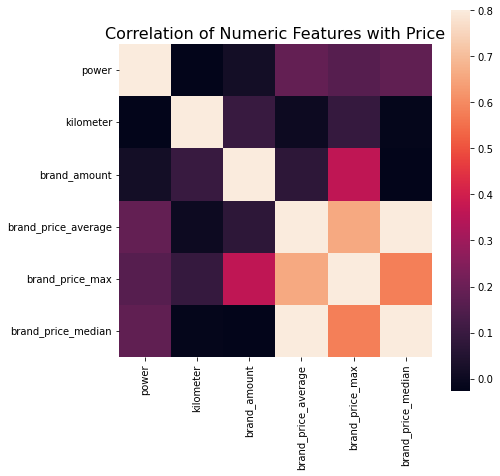

In [26]:
# 当然也可以直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)